# Average attack -- Randomized response

The basic idea of differential privacy is to make a particular query stochastic so that the underlying data is kept private. The average attack consists of performing the same query many times in order to reliably estimate the underlying data. This is, of course, not desirable so we should either limit the number of queries or design algorithms that are not vulnerable under this kind of attack.

In this notebook we present a simple example of this phenomenon based on a single node that contains a binary number  

The average attack consists of asking the same query many times. Then, one can reliably reconstruct the raw response (the error goes to zero as the number queries increases). There is no need to use many nodes, one node with one binary answer is enough. We define our own the randomized response algorithm.

In [2]:
import numpy as np
import scipy
import shfl
import matplotlib.pyplot as plt

In [4]:
from shfl.private.node import DataNode
from shfl.differential_privacy.dp_mechanism import RandomizedResponseBinary
from shfl.private.node

private_data = 1 #the node is guilty

node_single = DataNode()
# data_binary = np.array([private_data])  
node_single.set_private_data(name="guilty", data=private_data)
dp_mechanism = RandomizedResponseBinary(f1=0.8, f2=0.8)
data_access_definition = DataAccessDefinition(dp_mechanism=dp_mechanism)
node_single.configure_private_data_access("guilty", data_access_definition)

/home/diego/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/diego/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


NameError: name 'DataNode' is not defined

We perform the query N times and take the average.

In [14]:
N = 500
result_query = np.empty(N)
for i in range(N):
    result_query[i] = node_single.query_private_data(private_property="guilty")
print(np.mean(result_query))

0.788


We see that the average result of the query is close to 0.8. This allows us to conclude that the raw answer is most probably 1. Otherwise, the result would've been close to 0.2.

### Permanent randomized response

A possible way out is to do two independent randomized responses, as follows.

In [15]:
node_single_p = DataNode()
data_binary = np.array([1])  #the node is guilty
node_single_p.set_private_data(name="guilty", data=data_binary)
mech_permanent = RandomizeBinaryMine(f1=0.8, f2=0.8)
data_access_definition = DataAccessDefinition(dp_mechanism=mech_permanent)
node_single_p.configure_private_data_access("guilty", data_access_definition)

perm_response = node_single_p.query_private_data(private_property="guilty")
print(perm_response)

node_single_p.set_private_data(name="guilty", data=np.append(data_binary, perm_response))

[1.]


We get the randomize response of the raw data once, which we call **permanent random response**. Then, we append the result to the private data of the node, which now contains two binary numbers: the raw one and the permanent one. From now on, all the external queries are done over the permanent one. The raw remains completely hidden.

In [16]:
result_query = np.empty(N)
for i in range(N):
    result_query[i] = node_single_p.query_private_data(private_property="guilty")[1]
print(np.mean(result_query))

0.814


The result is not always close to 0.8, since the permanent response might be 0. The average attack may, at best, identify the permanent random response, but not the raw data.

### Sampler

In [17]:
from shfl.differential_privacy.sensitivity_sampler import SensitivitySampler
from shfl.private import IdentityFunction
from shfl.differential_privacy import L1SensitivityNorm
from shfl.differential_privacy import NormalDistribution

distribution = NormalDistribution(mean=0, std=1)
samp = SensitivitySampler()
sensitivity, mean = samp.sample_sensitivity(query=IdentityFunction(),
                                            sensitivity_norm=L1SensitivityNorm(),
                                            oracle=distribution, n=1, gamma=0.05)
print(sensitivity, mean)

4.493461969410383 1.1640437004558848


# Exponential Mechanism

In [18]:
class ExponentialMechanismAuction(DifferentialPrivacyMechanism):
    """
    Implements the Exponential mechanism for a particular utility function (the one in the notebook).
    The utility is rMax.
    
    # Arguments:
        sensitivity: float representing sensitivity of the applied query
        epsilon: float for the epsilon you want to apply
        u: utility function. ZZZ
    
    """
    def __init__(self, epsilon, rMin, rMax):
        self._epsilon = epsilon
        self._rMin = rMin
        self._rMax = rMax

    def set_area(self, data):
        x_intervals = np.sort(np.unique(np.append(data, [self._rMin, self._rMax])))
        area = 0
        for i in range(len(x_intervals) - 1):
            S = self._epsilon/(2*self._rMax) * sum(np.greater(data, x_intervals[i]))
            if S > 0:
                area_int = 1/S * (np.exp(S * x_intervals[i + 1]) - np.exp(S * x_intervals[i]))
            elif S == 0:
                area_int = x_intervals[i + 1] - x_intervals[i]
            area = area + area_int
        self._area = area

    def randomize(self, data):
        
        def CDF(self, r_range, data):
            output = np.zeros(len(r_range))
            for i in range(len(r_range)):
                r = r_range[i]
                x_intervals = np.sort(np.unique(np.append(data, [self._rMin, r, self._rMax])))
                x_intervals = x_intervals[x_intervals <= r]
                for j in range(len(x_intervals) - 1):
                    S = self._epsilon/(2*self._rMax) * sum(np.greater(data, x_intervals[j]))
                    if S > 0:
                        area_int = 1/S * (np.exp(S * x_intervals[j + 1]) - np.exp(S * x_intervals[j]))
                    elif S == 0:
                        area_int = x_intervals[j + 1] - x_intervals[j]
                    output[i] = output[i] + area_int
                output[i] = output[i] / self._area
            return output
        
        def CDF_inv(self, z, data):
            x_intervals = np.sort(np.unique(np.append(data, [self._rMin])))
            z_intervals = CDF(self, x_intervals, data)
            z_min = max(z_intervals[z_intervals <= z])
            x_min = max(x_intervals[z_intervals <= z])
            S = self._epsilon/(2*self._rMax) * sum(np.greater(data, x_min))
            if S > 0:
                r = 1/S * np.log(S * self._area * (z-z_min) + np.exp(S*x_min))
            else:
                r = x_min + self._area * (z-z_min)
            return r[0]
        
        z = np.random.uniform(size = 1)
        return CDF_inv(self, z, data)

In [19]:
data = [1.00, 1.00, 1.00, 3.01]

expp = ExponentialMechanismAuction(epsilon=5, rMin=0, rMax=3.5)
expp.set_area(data=data)
print(expp._area)
sample = expp.randomize(data=data)
print(sample)

15.393081679841128
0.9015545707262447


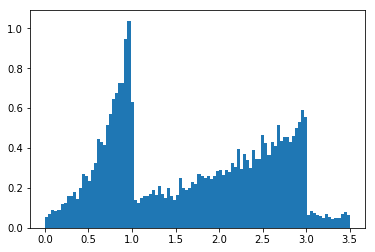

In [20]:
N = 10000
samples = np.zeros(N)
for i in range(N):
    samples[i] = expp.randomize(data=data)
plt.hist(samples, bins = int(round(np.sqrt(len(samples)))), density = True)
plt.show()

# Federated Linear Regression

We start by generating the data. Notice that the deviation from a linear relation is proportional to the predictor $x$.

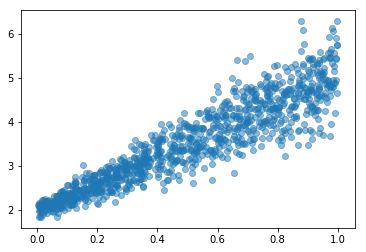

In [21]:
a, b = 2, 3
size = 1000
x = np.random.uniform(size=size)
y = a + b*x + np.random.normal(0, 0.1 + 0.5*x, size)

plt.scatter(x, y, alpha=0.5)
plt.show()

We split the data in train (0.8), test (0.1) and validation (0.1).

In [22]:
from shfl.data_base import data_base as db

class DataBaseExample(db.DataBase):
    
    def load_data(self, x, y, pTest, pVal):
        x1, y1, validation_data, validation_labels = db.extract_validation_samples(x, y, dim=int(pVal*size))
        train_data, train_labels, test_data, test_labels = db.extract_validation_samples(x1, y1, dim=int(pTest*size))
        self._train_data = train_data
        self._train_labels = train_labels
        self._test_data = test_data
        self._test_labels = test_labels
        self._validation_data = validation_data
        self._validation_labels = validation_labels

DB = DataBaseExample()
DB.load_data(x, y, pTest=0.1, pVal=0.1)

Now we want to split the data into $n$ different nodes.

In [23]:
from shfl.data_distribution.data_distribution_iid import IidDataDistribution

n = 90
distData = IidDataDistribution(DB)
federated_data, test_data, test_label = distData.get_federated_data(identifier="fed", num_nodes=n)#, weights=weights)

In [24]:
from shfl.private.federated_operation import apply_federated_transformation

class Reshape(shfl.private.FederatedTransformation):
    
    def apply(self, labeled_data):
        labeled_data.data = np.reshape(labeled_data.data, (-1,1))
        labeled_data.label = np.reshape(labeled_data.label, (-1,1))
        
apply_federated_transformation(federated_data, Reshape())
test_data = np.reshape(test_data, (-1,1))

Let's explore the output. In particular, federated_data is a FederatedData object. We can check the number of nodes and the data in each of them.

In [25]:
federated_data.num_nodes()

90

The data in the first node can be accessed by performing a trivial query.

In [26]:
from shfl.private.query import IdentityFunction
from shfl.private.data import DataAccessDefinition

query_id = IdentityFunction()
data_access_definition = DataAccessDefinition(query=query_id)
federated_data.configure_data_access(data_access_definition)
group_query = federated_data.query()
first_node = group_query[0]
print(first_node.data.shape)
print(first_node.label.shape)

print(first_node.data[0:5])
print(first_node.label[0:5])

(10, 1)
(10, 1)
[[0.3993984 ]
 [0.13901371]
 [0.95725048]
 [0.01748927]
 [0.5676761 ]]
[[3.20183393]
 [2.4520085 ]
 [4.24353266]
 [1.91818529]
 [4.11907649]]


Since we want to perform a federated linear regression, we define the corresponding class.

In [27]:
from shfl.model.model import TrainableModel
from sklearn.linear_model import LinearRegression

class LinearRegressionMine(TrainableModel):
    
    def __init__(self, regressor):
        self._regressor = regressor
    
    def train(self, data, labels):
        self._regressor.fit(data, labels)
        
    def predict(self, data):
        return self._regressor.predict(data)
        
    def get_model_params(self):
        return self._regressor.intercept_, self._regressor.coef_
    
    def set_model_params(self, params):
        self._regressor.intercept_ = np.reshape(np.array([params[0]]), (-1,1))
        self._regressor.coef_ = np.array([params[1]])
        
def model_builder():
    model = LinearRegressionMine(LinearRegression())
    return model

Aggregator: weighted according to the amount of data in each node.

In [28]:
from shfl.federated_aggregator.avgfed_aggregator import AvgFedAggregator
from shfl.federated_aggregator.weighted_avgfed_aggregator import WeightedAvgFedAggregator

aggregator = AvgFedAggregator()
# aggregator = WeightedAvgFedAggregator()

Learning approach.

In [29]:
from shfl.learning_approach.learning_approach import LearningApproach
from sklearn import metrics

class FederatedLinearRegression(LearningApproach):

    def train_all_clients(self):
        for data_node in self._federated_data:
            data_node.train_model(self._federated_data.identifier)
    
    def get_clients_rmse(self, data_test, label_test):
        rmse_test = 0
        for data_node in self._federated_data:
            prediction = data_node.predict(data_test)
            rmse_test += metrics.mean_squared_error(label_test, prediction)
        print("Mean RMSE: " + str(round(rmse_test / self._federated_data.num_nodes(), 3)))
    
    def aggregate_weights(self):
        weights = []
        for data_node in self._federated_data:
            weights.append(data_node.query_model_params())
        aggregated_weights = self._aggregator.aggregate_weights(weights)
        self._model.set_model_params(aggregated_weights)
        
    def get_global_model_rmse(self, data_test, label_test):
        prediction = self._model.predict(data_test)
        data_test = data_test.flatten()
        prediction = prediction.flatten()
        rmse_global_model_test = metrics.mean_squared_error(label_test, prediction)
        print("Global model test RMSE: " + str(round(rmse_global_model_test, 3)))

    def run_rounds(self, test_data, test_label):
        self.train_all_clients()
        self.get_clients_rmse(test_data, test_label)
        self.aggregate_weights()
        self.get_global_model_rmse(test_data, test_label)


In [30]:
fedLR = FederatedLinearRegression(model_builder, federated_data, aggregator)
regressor = fedLR.run_rounds(test_data, test_label)

Mean RMSE: 0.191
Global model test RMSE: 0.152


We perform a non-federated linear regression for comparison.

In [31]:
train_data, train_labels = DB.train
validation_data, validation_labels = DB.validation
x_train = np.reshape(np.concatenate([train_data, validation_data]), (-1,1))
y_train = np.concatenate([train_labels, validation_labels])

nonFedLR = LinearRegression().fit(x_train, y_train)
rmse_full = metrics.mean_squared_error(test_label, nonFedLR.predict(test_data))
print("Non-federated RMSE: " + str(round(rmse_full,3)))

Non-federated RMSE: 0.152
